# Self-supervised Vision Transformer for Land Cover Segmentation
### Pre-trained model with Swin Transformer and Sentinel-1/2, segmentation head trained with Flair1


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/BertilleT/LandCover_map_Transformers_SSL.git

Cloning into 'LandCover_map_Transformers_SSL'...
remote: Enumerating objects: 8612, done.
remote: Counting objects: 100% (195/195), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 8612 (delta 64), reused 179 (delta 49), pack-reused 8417
Receiving objects: 100% (8612/8612), 423.77 MiB | 21.77 MiB/s, done.
Resolving deltas: 100% (499/499), done.


In [3]:
cd LandCover_map_Transformers_SSL/src

/content/LandCover_map_Transformers_SSL/src


## Content

1. [Installation](#installation)
1. [Dataset](#dataset)
1. [Quick Start](#quickstart)

In [4]:
!pip install wandb
!pip install rasterio
!pip install timm
!pip install einops
!pip install diffdist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 862.8 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for diffdist: filename=diffdist-0.1-py3-none-any.whl size=6534 sha256=1f67c5e8238934d332a32d118dbdfa423f9b28764992924442498f4b568af01e
  Stored in directory: /root/.cache/pip/wheels/f1/29/f6/5331a14ab74e769799b76eb32460f447c7feb7375a16b07854
Successfully built diffdist


In [16]:
# Import needed packages
import argparse
import json
import os
import random
import numpy as np
import torch
import wandb
import torch.nn.functional as F
from distutils.util import strtobool
from tqdm import tqdm
from torchvision.models import resnet18, resnet50
from utils_B import *
import rasterio
from pathlib import Path
import numpy as np
from torchvision import transforms
from Transformer_SSL.models.swin_transformer import DoubleSwinTransformerDownstream
from Transformer_SSL.models import build_model
import torch.nn as nn
from Transformer_SSL.models.swin_transformer import SwinTransformerDecoder
import matplotlib.pyplot as plt
from metrics import PixelwiseMetrics
#from validation_utils import validate_all
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
# Data configurations:
data_config = {
    'train_dir': '../../drive/MyDrive/MVA/flair1_fullset_13classes/train', # path to the training directory,
    'val_dir': '../../drive/MyDrive/MVA/flair1_fullset_13classes/val', # path to the validation directory,
    'test_dir': '../../drive/MyDrive/MVA/flair1_fullset_13classes/test', # path to the validation directory,
    'train_mode': 'validation', # can be one of the following: 'test', 'validation'
    'val_mode': 'test', # can be one of the following: 'test', 'validation'
    'num_classes': 13, # number of classes in the dataset.
    'clip_sample_values': True, # clip (limit) values
    'train_used_data_fraction': 1, # fraction of data to use, should be in the range [0, 1]
    'val_used_data_fraction': 1,
    'image_px_size': 224, # image size (224x224)
    'cover_all_parts_train': True, # if True, if image_px_size is not 224 during training, we use a random crop of the image
    'cover_all_parts_validation': True, # if True, if image_px_size is not 224 during validation, we use a non-overlapping sliding window to cover the entire image
    'seed': 42,
}

In [60]:
# Ensure deterministic behavior
random.seed(data_config['seed'])
np.random.seed(data_config['seed'])
torch.manual_seed(data_config['seed'])
torch.cuda.manual_seed_all(data_config['seed'])

In [61]:
#from dfc_dataset import DFCDataset
size = 224
multimodal = True
train_dataset = Flair1Dataset_SSL(data_config['train_dir'], size, multimodal)
val_dataset = Flair1Dataset_SSL(data_config['val_dir'], size, multimodal)
test_dataset = Flair1Dataset_SSL(data_config['test_dir'], size, multimodal)

In [62]:
len(train_dataset), len(val_dataset)

(1664, 416)

In [63]:
#loop on train_ds and check shape of rgb and ir_el
rgb = train_dataset[0][0]['rgb']
ir_el = train_dataset[0][0]['ir_el']
print(rgb.shape)
print(ir_el.shape)

torch.Size([3, 224, 224])
torch.Size([2, 224, 224])


In [64]:
dict_classes_13 = {
1   : 'building',
2   : 'pervious surface',
3   : 'impervious surface',
4   : 'bare soil',
5   : 'water',
6   : 'coniferous',
7   : 'deciduous',
8   : 'brushwood',
9   : 'vineyard',
10  : 'herbaceous vegetation',
11  : 'agricultural land',
12  : 'plowed land',
13  : 'other'}

In [65]:
# Training configurations
train_config = {
    's1_input_channels': 2,
    's2_input_channels': 13,
    'finetuning': True, # If false, backbone layers is frozen and only the head is trained
    'classifier_lr': 3e-6,
    'learning_rate': 0.00001,
    'adam_betas': (0.9, 0.999),
    'weight_decay': 0.001,
    'dataloader_workers': 4,
    'batch_size': 16,
    'epochs': 60,
    'target': 'dfc_label'
}

#### Download checkpoint

You can download the pre-trained backbone model using this [link](https://drive.google.com/file/d/1e7QhC2-zoBFgb65yN1ADWBZLMShHOweY/view), save it in the `checkpoints/` directory then run the following cell.

In [66]:
# path to the checkpoint
checkpoint = torch.load(
    "../../drive/MyDrive/MVA/swin_t.pth",#, map_location=torch.device('cpu') #comment map_location if using GPU
)
weights = checkpoint["state_dict"]

# Sentinel-1 stream weights
s1_weights = {
    k[len("backbone1."):]: v for k, v in weights.items() if "backbone1" in k
}

# Sentinel-2 stream weights
s2_weights = {
    k[len("backbone2."):]: v for k, v in weights.items() if "backbone2" in k
}

#### Prepare model and load checkpoint

In [67]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""

    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def dotdictify(d):
    """recursively wrap a dictionary and
    all the dictionaries that it contains
    with the dotdict class
    """
    d = dotdict(d)
    for k, v in d.items():
        if isinstance(v, dict):
            d[k] = dotdictify(v)
    return d

In [68]:

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu:0")

with open("configs/backbone_config.json", "r") as fp:
    swin_conf = dotdictify(json.load(fp))

s1_backbone = build_model(swin_conf.model_config)

swin_conf.model_config.MODEL.SWIN.IN_CHANS = 13
s2_backbone = build_model(swin_conf.model_config)

s1_backbone.load_state_dict(s1_weights)
s2_backbone.load_state_dict(s2_weights)

<All keys matched successfully>

We create the downstream model head that will be trained. In this demo, we will train a segmentation head. You can find a segmentation head in the repository (/TransformerSSL/models/swin_transformer/DoubleSwinTransformerSegmentation). Our classifier takes as input the pre-trained backbone (in the form of two streams `encoder1` and `encoder2`), the `out_dim` (number of classes), and `freeze_layers` flag, specifying whether you wish to freeze the backbone weights or not.

In [69]:
class DoubleSwinTransformerSegmentation(nn.Module):
    def __init__(self, encoder1, encoder2, out_dim, device, freeze_layers=False):
        super(DoubleSwinTransformerSegmentation, self).__init__()

        self.device = device

        self.backbone1 = encoder1
        self.backbone2 = encoder2

        self.decoder1 = SwinTransformerDecoder(self.backbone1, out_dim, device)
        self.decoder2 = SwinTransformerDecoder(self.backbone2, out_dim, device)

        # freeze all backbone layers
        if freeze_layers:
            for name, param in self.named_parameters():
                if name.startswith(('backbone')):
                    param.requires_grad = False

        self.expand_channels = torch.nn.Conv2d(3, 13, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        expanded_rgb = self.expand_channels(x["rgb"].to(self.device))
        _, x2, x_seg2 = self.backbone2.forward_features(expanded_rgb)

        _, x1, x_seg1 = self.backbone1.forward_features(x["ir_el"].to(self.device))

        x1 = self.decoder1.forward_up_features(x1, x_seg1)
        x2 = self.decoder2.forward_up_features(x2, x_seg2)

        x = torch.cat([x1, x2], dim=-1)

        output = self.decoder1.up_x4(x)

        return output

In [70]:
model = DoubleSwinTransformerSegmentation(
        s1_backbone, s2_backbone, out_dim=data_config['num_classes'], device=device
    )

model = model.to(device)
criterion = torch.nn.CrossEntropyLoss(ignore_index=255, reduction="mean").to(device)

Define the trainable parameters (needed for the optimizer):

In [72]:
if train_config['finetuning']:
    # train all parameters (backbone + classifier head)
    param_backbone = []
    param_head = []
    for p in model.parameters():
        if p.requires_grad:
            param_head.append(p)
        else:
            param_backbone.append(p)
        p.requires_grad = True
    # parameters = model.parameters()
    parameters = [
        {"params": param_backbone},  # train with default lr
        {
            "params": param_head,
            "lr": train_config['classifier_lr'],
        },  # train with classifier lr
    ]
    print("Finetuning")

else:
    # train only final linear layer for SSL methods
    print("Frozen backbone")
    parameters = list(filter(lambda p: p.requires_grad, model.parameters()))

Finetuning


Initialise the selected optimizer. In this work we chose Adam optimizer. You can initialise any optimizer you want.

In [73]:
optimizer = torch.optim.Adam(
    parameters,
    lr=train_config['learning_rate'],
    betas=train_config['adam_betas'],
    weight_decay=train_config['weight_decay'],
)

We load the data (training and validation) using pytorch's dataloader

In [74]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_config['batch_size'],
    shuffle=True,
    pin_memory=True,
    num_workers=train_config['dataloader_workers'],
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=train_config['batch_size'],
    shuffle=False,
    num_workers=train_config['dataloader_workers'],
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=train_config['batch_size'],
    shuffle=False,
    num_workers=train_config['dataloader_workers'],
)

Everything is set and we are now ready to train the segmentation head:

In [75]:
step = 0

#Training loop
train_losses = []
val_losses = []
patience = 3
best_loss = float('inf')
patience_counter = 0
# Restaurer les poids du modèle et l'état de l'optimiseur
# model.load_state_dict(torch.load("checkpoints/segmentation-epoch-6.pth"))

# Restaurer le numéro de l'époque
#start_epoch = 6 + 1
for epoch in range(train_config['epochs']):
    # Model Training
    model.train()
    step += 1

    pbar = tqdm(train_loader)

    # track performance
    epoch_losses = torch.Tensor()
    metrics = PixelwiseMetrics(data_config['num_classes'])

    for idx, (img, y) in enumerate(pbar):
        # load target
        y = y.to(device)
        # model output
        y_hat = model(img)

        # loss computation
        loss = criterion(y_hat, y)

        # backward step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # get prediction
        _, pred = torch.max(y_hat, dim=1)

        epoch_losses = torch.cat([epoch_losses, loss[None].detach().cpu()])
        metrics.add_batch(y, pred)

        pbar.set_description(f"Epoch:{epoch}, Training Loss:{epoch_losses[-100:].mean():.4}")

    mean_loss = epoch_losses.mean()
    train_losses.append(mean_loss)
    train_stats = {
            "train_loss": mean_loss.item(),
            "train_average_accuracy": metrics.get_average_accuracy(),
            "train_mIoU": metrics.get_mIoU(),
            **{
                "train_accuracy_" + k: v
                for k, v in metrics.get_classwise_accuracy().items()
            },
            **{
                "train_IoU_" + k: v
                for k, v in metrics.get_IoU().items()
            },
        }
    print(train_stats)

    # Model Validation
    model.eval()
    pbar = tqdm(val_loader)

    # track performance
    epoch_losses = torch.Tensor()
    metrics = PixelwiseMetrics(data_config['num_classes'])

    with torch.no_grad():
        for idx, (img, y) in enumerate(pbar):
            y = y.to(device)
            # model output
            y_hat = model(img)

            # loss computation
            loss = criterion(y_hat, y)

            # get prediction
            _, pred = torch.max(y_hat, dim=1)

            epoch_losses = torch.cat([epoch_losses, loss[None].detach().cpu()])
            metrics.add_batch(y, pred)


            pbar.set_description(f"Validation Loss:{epoch_losses[-100:].mean():.4}")

        mean_loss = epoch_losses.mean()
        val_losses.append(mean_loss)
        val_stats = {
            "validation_loss": mean_loss.item(),
            "validation_average_accuracy": metrics.get_average_accuracy(),
            "validation_mIoU": metrics.get_mIoU(),
            **{
                "validation_accuracy_" + k: v
                for k, v in metrics.get_classwise_accuracy().items()
            },
            **{
            "train_IoU_" + k: v
            for k, v in metrics.get_IoU().items()
        },
        }

        print(f"Epoch:{epoch}", val_stats)

        # Save model checkpoint every 2 epochs
        if epoch % 2 == 0:
            if epoch == 0:
                continue

            save_weights_path = (
                "checkpoints/" + "-".join(["segmentation", "epoch", str(epoch)]) + ".pth"
            )
            torch.save(model.state_dict(), save_weights_path)
        val_loss = val_stats["validation_loss"]
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            # Enregistrez les meilleurs poids ici si désiré
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch} epochs.")
                torch.save(model.state_dict(), '../../drive/MyDrive/MVA/swin-t_SSL_finetune_'+str(epoch)+'.pth')
                break
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

Epoch:0, Training Loss:2.459: 100%|██████████| 104/104 [05:03<00:00,  2.92s/it]


{'train_loss': 2.468355894088745, 'train_average_accuracy': 0.08514640966850277, 'train_mIoU': 0.04566974839685131, 'train_accuracy_pixelclass_0': 0.03384328841652238, 'train_accuracy_pixelclass_1': 0.03865121168776574, 'train_accuracy_pixelclass_2': 0.07463125611526233, 'train_accuracy_pixelclass_3': 0.028496703325088954, 'train_accuracy_pixelclass_4': 0.045492455472507076, 'train_accuracy_pixelclass_5': 0.03502884133488402, 'train_accuracy_pixelclass_6': 0.12325388747875142, 'train_accuracy_pixelclass_7': 0.054412082681746694, 'train_accuracy_pixelclass_8': 0.11130669125881945, 'train_accuracy_pixelclass_9': 0.4039250379638047, 'train_accuracy_pixelclass_10': 0.08597933539416203, 'train_accuracy_pixelclass_11': 0.013319334691946723, 'train_accuracy_pixelclass_12': 0.05856319986927452, 'train_IoU_class_0': 0.023030290146841992, 'train_IoU_class_1': 0.023508923429622963, 'train_IoU_class_2': 0.04559630373274586, 'train_IoU_class_3': 0.006696342535644883, 'train_IoU_class_4': 0.02098780

Validation Loss:2.317: 100%|██████████| 26/26 [00:24<00:00,  1.05it/s]


Epoch:0 {'validation_loss': 2.3169445991516113, 'validation_average_accuracy': 0.09563832559478101, 'validation_mIoU': 0.05144535809628599, 'validation_accuracy_pixelclass_0': 0.009572455886823053, 'validation_accuracy_pixelclass_1': 0.017153128564445168, 'validation_accuracy_pixelclass_2': 0.06597145391378681, 'validation_accuracy_pixelclass_3': 0.010555608866711448, 'validation_accuracy_pixelclass_4': 0.010201415196954894, 'validation_accuracy_pixelclass_5': 0.01776302985106264, 'validation_accuracy_pixelclass_6': 0.23001398893702704, 'validation_accuracy_pixelclass_7': 0.031062112166351904, 'validation_accuracy_pixelclass_8': 0.0615665078009926, 'validation_accuracy_pixelclass_9': 0.7393521786011489, 'validation_accuracy_pixelclass_10': 0.04616946234468693, 'validation_accuracy_pixelclass_11': 0.0022449992750980816, 'validation_accuracy_pixelclass_12': 0.001671891327063741, 'train_IoU_class_0': 0.00825779585934131, 'train_IoU_class_1': 0.012778309269528023, 'train_IoU_class_2': 0.04

Epoch:1, Training Loss:2.249: 100%|██████████| 104/104 [04:51<00:00,  2.80s/it]


{'train_loss': 2.251753330230713, 'train_average_accuracy': 0.10235364265360908, 'train_mIoU': 0.05283915799458576, 'train_accuracy_pixelclass_0': 0.005254206822172753, 'train_accuracy_pixelclass_1': 0.00866459929359112, 'train_accuracy_pixelclass_2': 0.03487390120516742, 'train_accuracy_pixelclass_3': 0.005902371926924244, 'train_accuracy_pixelclass_4': 0.009186316210511712, 'train_accuracy_pixelclass_5': 0.02209998542238377, 'train_accuracy_pixelclass_6': 0.3039457902985886, 'train_accuracy_pixelclass_7': 0.020672051620914293, 'train_accuracy_pixelclass_8': 0.032505017587821816, 'train_accuracy_pixelclass_9': 0.8481222138022495, 'train_accuracy_pixelclass_10': 0.036567912801748016, 'train_accuracy_pixelclass_11': 0.0011916143879952335, 'train_accuracy_pixelclass_12': 0.0016113731168495159, 'train_IoU_class_0': 0.0047356723985534505, 'train_IoU_class_1': 0.007222524631519392, 'train_IoU_class_2': 0.027350306473655682, 'train_IoU_class_3': 0.003669928111167503, 'train_IoU_class_4': 0.0

Validation Loss:2.158: 100%|██████████| 26/26 [00:22<00:00,  1.16it/s]


Epoch:1 {'validation_loss': 2.157782793045044, 'validation_average_accuracy': 0.11020635181063494, 'validation_mIoU': 0.056368734390599126, 'validation_accuracy_pixelclass_0': 0.0013037282993869144, 'validation_accuracy_pixelclass_1': 0.004367972950953235, 'validation_accuracy_pixelclass_2': 0.017832793389805184, 'validation_accuracy_pixelclass_3': 0.000934567741558642, 'validation_accuracy_pixelclass_4': 0.016246316870759333, 'validation_accuracy_pixelclass_5': 0.024919885228242792, 'validation_accuracy_pixelclass_6': 0.40960340053348016, 'validation_accuracy_pixelclass_7': 0.013963141767187522, 'validation_accuracy_pixelclass_8': 0.008252493221626998, 'validation_accuracy_pixelclass_9': 0.9194899071854205, 'validation_accuracy_pixelclass_10': 0.015724432900222497, 'validation_accuracy_pixelclass_11': 4.393344961052997e-05, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.0012492887473049812, 'train_IoU_class_1': 0.0038033873114600874, 'train_IoU_class_2': 0.0155215780

Epoch:2, Training Loss:2.119: 100%|██████████| 104/104 [04:48<00:00,  2.77s/it]


{'train_loss': 2.1237025260925293, 'train_average_accuracy': 0.11720059410725162, 'train_mIoU': 0.05951184117197848, 'train_accuracy_pixelclass_0': 0.0021231911778487557, 'train_accuracy_pixelclass_1': 0.002324835712437025, 'train_accuracy_pixelclass_2': 0.015284236269183835, 'train_accuracy_pixelclass_3': 0.00039521352508508067, 'train_accuracy_pixelclass_4': 0.019285886344753676, 'train_accuracy_pixelclass_5': 0.020723624357175008, 'train_accuracy_pixelclass_6': 0.5073386143174337, 'train_accuracy_pixelclass_7': 0.012294598806553458, 'train_accuracy_pixelclass_8': 0.011616654851265543, 'train_accuracy_pixelclass_9': 0.917044981797451, 'train_accuracy_pixelclass_10': 0.015073675698238387, 'train_accuracy_pixelclass_11': 1.5968031999936128e-05, 'train_accuracy_pixelclass_12': 8.624250484546704e-05, 'train_IoU_class_0': 0.00203989354766812, 'train_IoU_class_1': 0.002151666262215504, 'train_IoU_class_2': 0.01364968506498104, 'train_IoU_class_3': 0.00036908513925727044, 'train_IoU_class_4

Validation Loss:2.046: 100%|██████████| 26/26 [00:23<00:00,  1.09it/s]


Epoch:2 {'validation_loss': 2.04587459564209, 'validation_average_accuracy': 0.12579110212440586, 'validation_mIoU': 0.06425168609879418, 'validation_accuracy_pixelclass_0': 0.0018591508901404411, 'validation_accuracy_pixelclass_1': 0.0010744256151213947, 'validation_accuracy_pixelclass_2': 0.016886710202568656, 'validation_accuracy_pixelclass_3': 0.0005173499997913911, 'validation_accuracy_pixelclass_4': 0.02207367417001672, 'validation_accuracy_pixelclass_5': 0.01474535738992529, 'validation_accuracy_pixelclass_6': 0.6415529835330859, 'validation_accuracy_pixelclass_7': 0.011383487499642029, 'validation_accuracy_pixelclass_8': 0.0071964508532775424, 'validation_accuracy_pixelclass_9': 0.9067299912711942, 'validation_accuracy_pixelclass_10': 0.011251566157629414, 'validation_accuracy_pixelclass_11': 1.3180034883158991e-05, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.0018062477924728228, 'train_IoU_class_1': 0.0010460759262729653, 'train_IoU_class_2': 0.01518846092

Epoch:3, Training Loss:2.023: 100%|██████████| 104/104 [05:18<00:00,  3.07s/it]


{'train_loss': 2.0262484550476074, 'train_average_accuracy': 0.12840189237049493, 'train_mIoU': 0.0649159234807103, 'train_accuracy_pixelclass_0': 0.0036464502609435756, 'train_accuracy_pixelclass_1': 0.0008908523141513514, 'train_accuracy_pixelclass_2': 0.01169764119637102, 'train_accuracy_pixelclass_3': 0.0003603417434599265, 'train_accuracy_pixelclass_4': 0.021286453389524437, 'train_accuracy_pixelclass_5': 0.004447769039484059, 'train_accuracy_pixelclass_6': 0.6733436502301433, 'train_accuracy_pixelclass_7': 0.007992556884298847, 'train_accuracy_pixelclass_8': 0.009864492747991742, 'train_accuracy_pixelclass_9': 0.9263873772625564, 'train_accuracy_pixelclass_10': 0.00930247666830711, 'train_accuracy_pixelclass_11': 0.0, 'train_accuracy_pixelclass_12': 4.539079202393002e-06, 'train_IoU_class_0': 0.0035942325703949415, 'train_IoU_class_1': 0.0008813326249335875, 'train_IoU_class_2': 0.010819639189948205, 'train_IoU_class_3': 0.0003489026449071469, 'train_IoU_class_4': 0.0205451348002

Validation Loss:1.957: 100%|██████████| 26/26 [00:24<00:00,  1.05it/s]


Epoch:3 {'validation_loss': 1.9573376178741455, 'validation_average_accuracy': 0.13286916634501675, 'validation_mIoU': 0.06844514704458887, 'validation_accuracy_pixelclass_0': 0.005718832966249494, 'validation_accuracy_pixelclass_1': 0.0009725843245885612, 'validation_accuracy_pixelclass_2': 0.015351984552508798, 'validation_accuracy_pixelclass_3': 0.0005131778223737186, 'validation_accuracy_pixelclass_4': 0.02102199515223601, 'validation_accuracy_pixelclass_5': 0.0010791165889124624, 'validation_accuracy_pixelclass_6': 0.7259787914960144, 'validation_accuracy_pixelclass_7': 0.007668122165432482, 'validation_accuracy_pixelclass_8': 0.012117807653697849, 'validation_accuracy_pixelclass_9': 0.9224720719231719, 'validation_accuracy_pixelclass_10': 0.01440467784003204, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.005655280542060088, 'train_IoU_class_1': 0.0009655720483574659, 'train_IoU_class_2': 0.013976303558254112, 'train_IoU

Epoch:4, Training Loss:1.952: 100%|██████████| 104/104 [05:23<00:00,  3.11s/it]


{'train_loss': 1.950380802154541, 'train_average_accuracy': 0.1359049554030589, 'train_mIoU': 0.069419484439561, 'train_accuracy_pixelclass_0': 0.007892832616641088, 'train_accuracy_pixelclass_1': 0.0006850627218245955, 'train_accuracy_pixelclass_2': 0.01444352636214233, 'train_accuracy_pixelclass_3': 0.0022330855714774657, 'train_accuracy_pixelclass_4': 0.027071773803231645, 'train_accuracy_pixelclass_5': 0.00041072699742603986, 'train_accuracy_pixelclass_6': 0.7570768168608215, 'train_accuracy_pixelclass_7': 0.007119946670829644, 'train_accuracy_pixelclass_8': 0.017555872743668544, 'train_accuracy_pixelclass_9': 0.9190767476618233, 'train_accuracy_pixelclass_10': 0.013198028229879885, 'train_accuracy_pixelclass_11': 0.0, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.007791248626895112, 'train_IoU_class_1': 0.0006805487249126114, 'train_IoU_class_2': 0.013235415941094293, 'train_IoU_class_3': 0.002167266874660777, 'train_IoU_class_4': 0.026655470926061114, 'train_IoU_cla

Validation Loss:1.893: 100%|██████████| 26/26 [00:23<00:00,  1.09it/s]


Epoch:4 {'validation_loss': 1.8925138711929321, 'validation_average_accuracy': 0.1330063372102646, 'validation_mIoU': 0.0694791381248639, 'validation_accuracy_pixelclass_0': 0.004400966637279762, 'validation_accuracy_pixelclass_1': 0.0008768535114876976, 'validation_accuracy_pixelclass_2': 0.006276961716018072, 'validation_accuracy_pixelclass_3': 2.9205241923707564e-05, 'validation_accuracy_pixelclass_4': 0.026644680525144397, 'validation_accuracy_pixelclass_5': 5.7809817263167634e-06, 'validation_accuracy_pixelclass_6': 0.7241521160358806, 'validation_accuracy_pixelclass_7': 0.0056099755675164025, 'validation_accuracy_pixelclass_8': 0.00977234986724709, 'validation_accuracy_pixelclass_9': 0.9462386989613237, 'validation_accuracy_pixelclass_10': 0.005074794687892415, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.004362545772695148, 'train_IoU_class_1': 0.0008731906141643484, 'train_IoU_class_2': 0.005887434522468571, 'train_I

Epoch:5, Training Loss:1.884: 100%|██████████| 104/104 [04:52<00:00,  2.82s/it]


{'train_loss': 1.885422945022583, 'train_average_accuracy': 0.1406745216892392, 'train_mIoU': 0.07313899896938274, 'train_accuracy_pixelclass_0': 0.012678718567578266, 'train_accuracy_pixelclass_1': 0.0012448916456871848, 'train_accuracy_pixelclass_2': 0.02388811233824913, 'train_accuracy_pixelclass_3': 0.00857716673232033, 'train_accuracy_pixelclass_4': 0.033397091397625346, 'train_accuracy_pixelclass_5': 4.4690502310605376e-05, 'train_accuracy_pixelclass_6': 0.7863243231269667, 'train_accuracy_pixelclass_7': 0.007644984195939841, 'train_accuracy_pixelclass_8': 0.029088337465125857, 'train_accuracy_pixelclass_9': 0.9092367800592636, 'train_accuracy_pixelclass_10': 0.01664368592904276, 'train_accuracy_pixelclass_11': 0.0, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.012441875015390274, 'train_IoU_class_1': 0.001232826296182663, 'train_IoU_class_2': 0.0211288331024909, 'train_IoU_class_3': 0.008306670102241712, 'train_IoU_class_4': 0.03294584593671876, 'train_IoU_class_5'

Validation Loss:1.826: 100%|██████████| 26/26 [00:22<00:00,  1.15it/s]


Epoch:5 {'validation_loss': 1.8262381553649902, 'validation_average_accuracy': 0.1400245860556366, 'validation_mIoU': 0.07321464606153844, 'validation_accuracy_pixelclass_0': 0.012516195617816745, 'validation_accuracy_pixelclass_1': 0.0013066237575362555, 'validation_accuracy_pixelclass_2': 0.028502115330424637, 'validation_accuracy_pixelclass_3': 1.2516532253017527e-05, 'validation_accuracy_pixelclass_4': 0.03034808387172348, 'validation_accuracy_pixelclass_5': 1.926993908772254e-06, 'validation_accuracy_pixelclass_6': 0.7964320791487806, 'validation_accuracy_pixelclass_7': 0.0035540898410004506, 'validation_accuracy_pixelclass_8': 0.01943094503185132, 'validation_accuracy_pixelclass_9': 0.9184809143583538, 'validation_accuracy_pixelclass_10': 0.009734128239627141, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.012305730991597272, 'train_IoU_class_1': 0.0012962332452002494, 'train_IoU_class_2': 0.024871132850953083, 'train_Io

Epoch:6, Training Loss:1.823: 100%|██████████| 104/104 [05:03<00:00,  2.92s/it]


{'train_loss': 1.8244379758834839, 'train_average_accuracy': 0.1453850125320824, 'train_mIoU': 0.07733138360858537, 'train_accuracy_pixelclass_0': 0.027691615955377138, 'train_accuracy_pixelclass_1': 0.0017153645623552618, 'train_accuracy_pixelclass_2': 0.04829011674212546, 'train_accuracy_pixelclass_3': 0.0048019734845304906, 'train_accuracy_pixelclass_4': 0.03873374002301909, 'train_accuracy_pixelclass_5': 2.7133519260010406e-05, 'train_accuracy_pixelclass_6': 0.8039185664067658, 'train_accuracy_pixelclass_7': 0.009280747039037779, 'train_accuracy_pixelclass_8': 0.03066693837771808, 'train_accuracy_pixelclass_9': 0.906857865413974, 'train_accuracy_pixelclass_10': 0.018019105388908597, 'train_accuracy_pixelclass_11': 1.996003999992016e-06, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.02705157403551163, 'train_IoU_class_1': 0.0016920296766246834, 'train_IoU_class_2': 0.04091305170750329, 'train_IoU_class_3': 0.004675200563337777, 'train_IoU_class_4': 0.03795985688611606,

Validation Loss:1.778: 100%|██████████| 26/26 [00:22<00:00,  1.14it/s]


Epoch:6 {'validation_loss': 1.7777085304260254, 'validation_average_accuracy': 0.14939993576040675, 'validation_mIoU': 0.08077621509996115, 'validation_accuracy_pixelclass_0': 0.030784549557328195, 'validation_accuracy_pixelclass_1': 0.0035736108847971323, 'validation_accuracy_pixelclass_2': 0.085341809784798, 'validation_accuracy_pixelclass_3': 0.00017940362895991788, 'validation_accuracy_pixelclass_4': 0.04682867929968733, 'validation_accuracy_pixelclass_5': 1.1561963452633527e-05, 'validation_accuracy_pixelclass_6': 0.816461420873161, 'validation_accuracy_pixelclass_7': 0.01512447604305302, 'validation_accuracy_pixelclass_8': 0.0437955605175018, 'validation_accuracy_pixelclass_9': 0.8818117269819143, 'validation_accuracy_pixelclass_10': 0.01828636535063471, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.030080975095668237, 'train_IoU_class_1': 0.0034911740652229717, 'train_IoU_class_2': 0.068434062913493, 'train_IoU_class_3

Epoch:7, Training Loss:1.773: 100%|██████████| 104/104 [05:04<00:00,  2.93s/it]


{'train_loss': 1.773164987564087, 'train_average_accuracy': 0.15344150656951605, 'train_mIoU': 0.08516834008215926, 'train_accuracy_pixelclass_0': 0.05097143934028466, 'train_accuracy_pixelclass_1': 0.003443590974230946, 'train_accuracy_pixelclass_2': 0.07833605937908633, 'train_accuracy_pixelclass_3': 0.006112894164142768, 'train_accuracy_pixelclass_4': 0.052702388365845065, 'train_accuracy_pixelclass_5': 5.426703852002081e-05, 'train_accuracy_pixelclass_6': 0.8211934785082592, 'train_accuracy_pixelclass_7': 0.012955291960161028, 'train_accuracy_pixelclass_8': 0.04846962492073895, 'train_accuracy_pixelclass_9': 0.8906998055624425, 'train_accuracy_pixelclass_10': 0.02971292101399746, 'train_accuracy_pixelclass_11': 8.78241759996487e-05, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.049172848493351885, 'train_IoU_class_1': 0.0033517926083539823, 'train_IoU_class_2': 0.06346077289259627, 'train_IoU_class_3': 0.005988281541593442, 'train_IoU_class_4': 0.0510402474738432, 'tr

Validation Loss:1.724: 100%|██████████| 26/26 [00:24<00:00,  1.07it/s]


Epoch:7 {'validation_loss': 1.7241103649139404, 'validation_average_accuracy': 0.1482864584764633, 'validation_mIoU': 0.08351811439146302, 'validation_accuracy_pixelclass_0': 0.03565914018563233, 'validation_accuracy_pixelclass_1': 0.0035664819944598337, 'validation_accuracy_pixelclass_2': 0.0648679265979397, 'validation_accuracy_pixelclass_3': 0.000696753628751309, 'validation_accuracy_pixelclass_4': 0.05359572531740239, 'validation_accuracy_pixelclass_5': 1.926993908772254e-06, 'validation_accuracy_pixelclass_6': 0.7711629633815659, 'validation_accuracy_pixelclass_7': 0.012321749130694946, 'validation_accuracy_pixelclass_8': 0.043376896302620344, 'validation_accuracy_pixelclass_9': 0.9224574884676768, 'validation_accuracy_pixelclass_10': 0.02001690819337029, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.03475971098379698, 'train_IoU_class_1': 0.003480815755313164, 'train_IoU_class_2': 0.053092735631472224, 'train_IoU_class_

Epoch:8, Training Loss:1.719: 100%|██████████| 104/104 [04:59<00:00,  2.88s/it]


{'train_loss': 1.7219706773757935, 'train_average_accuracy': 0.16201163341649566, 'train_mIoU': 0.09293082711710625, 'train_accuracy_pixelclass_0': 0.08460194774368689, 'train_accuracy_pixelclass_1': 0.006059285003015765, 'train_accuracy_pixelclass_2': 0.11457781512688567, 'train_accuracy_pixelclass_3': 0.006390576869676403, 'train_accuracy_pixelclass_4': 0.08305646677649049, 'train_accuracy_pixelclass_5': 6.597169388708413e-05, 'train_accuracy_pixelclass_6': 0.8263880845252805, 'train_accuracy_pixelclass_7': 0.012896615517676053, 'train_accuracy_pixelclass_8': 0.05041391321767768, 'train_accuracy_pixelclass_9': 0.8950179208457201, 'train_accuracy_pixelclass_10': 0.026293416314448724, 'train_accuracy_pixelclass_11': 0.00038922077999844313, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.08080845631215179, 'train_IoU_class_1': 0.0058226040980482036, 'train_IoU_class_2': 0.08892550653621331, 'train_IoU_class_3': 0.006350306413835146, 'train_IoU_class_4': 0.08066464099052102, 

Validation Loss:1.684: 100%|██████████| 26/26 [00:24<00:00,  1.05it/s]


Epoch:8 {'validation_loss': 1.6842702627182007, 'validation_average_accuracy': 0.17424183508020066, 'validation_mIoU': 0.10449554929034723, 'validation_accuracy_pixelclass_0': 0.11835146535627329, 'validation_accuracy_pixelclass_1': 0.01096932540329151, 'validation_accuracy_pixelclass_2': 0.23250431671139404, 'validation_accuracy_pixelclass_3': 0.0016480100799806411, 'validation_accuracy_pixelclass_4': 0.09589201560655619, 'validation_accuracy_pixelclass_5': 7.322576853334566e-05, 'validation_accuracy_pixelclass_6': 0.8159101980329616, 'validation_accuracy_pixelclass_7': 0.027779326893366756, 'validation_accuracy_pixelclass_8': 0.05834678062464232, 'validation_accuracy_pixelclass_9': 0.8557117470645479, 'validation_accuracy_pixelclass_10': 0.04425385469889349, 'validation_accuracy_pixelclass_11': 0.0037035898021676762, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.10952109053834444, 'train_IoU_class_1': 0.010184649366662506, 'train_IoU_class_2': 0.15630482930128717, 

Epoch:9, Training Loss:1.671: 100%|██████████| 104/104 [04:55<00:00,  2.84s/it]


{'train_loss': 1.6749848127365112, 'train_average_accuracy': 0.17574170978954745, 'train_mIoU': 0.10583963124260577, 'train_accuracy_pixelclass_0': 0.14157219592558282, 'train_accuracy_pixelclass_1': 0.008248507179281321, 'train_accuracy_pixelclass_2': 0.1783390057093728, 'train_accuracy_pixelclass_3': 0.01005340548778519, 'train_accuracy_pixelclass_4': 0.12640516208029698, 'train_accuracy_pixelclass_5': 0.0005043642403625464, 'train_accuracy_pixelclass_6': 0.834913559070688, 'train_accuracy_pixelclass_7': 0.012643607004208733, 'train_accuracy_pixelclass_8': 0.05648841097678108, 'train_accuracy_pixelclass_9': 0.882873355362223, 'train_accuracy_pixelclass_10': 0.03155120705433576, 'train_accuracy_pixelclass_11': 0.0010449080939958205, 'train_accuracy_pixelclass_12': 4.539079202393002e-06, 'train_IoU_class_0': 0.13106567696516613, 'train_IoU_class_1': 0.007802111724617792, 'train_IoU_class_2': 0.13146399587389346, 'train_IoU_class_3': 0.00997786257878525, 'train_IoU_class_4': 0.121662632

Validation Loss:1.644: 100%|██████████| 26/26 [00:22<00:00,  1.18it/s]


Epoch:9 {'validation_loss': 1.6444288492202759, 'validation_average_accuracy': 0.1851825611625219, 'validation_mIoU': 0.11525325804189737, 'validation_accuracy_pixelclass_0': 0.10783479106516924, 'validation_accuracy_pixelclass_1': 0.008786866547172886, 'validation_accuracy_pixelclass_2': 0.151234305231684, 'validation_accuracy_pixelclass_3': 0.002728604031157821, 'validation_accuracy_pixelclass_4': 0.20383779170576674, 'validation_accuracy_pixelclass_5': 0.000901833149305415, 'validation_accuracy_pixelclass_6': 0.8407657388169798, 'validation_accuracy_pixelclass_7': 0.037082059081091426, 'validation_accuracy_pixelclass_8': 0.1502529576222687, 'validation_accuracy_pixelclass_9': 0.849649586908432, 'validation_accuracy_pixelclass_10': 0.0542987609537567, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.10179932999410837, 'train_IoU_class_1': 0.008355469646538842, 'train_IoU_class_2': 0.11743235265611095, 'train_IoU_class_3': 0.00

Epoch:10, Training Loss:1.628: 100%|██████████| 104/104 [04:56<00:00,  2.85s/it]


{'train_loss': 1.6300911903381348, 'train_average_accuracy': 0.1930927864941062, 'train_mIoU': 0.12214404958215727, 'train_accuracy_pixelclass_0': 0.1807554689072325, 'train_accuracy_pixelclass_1': 0.008543427132319774, 'train_accuracy_pixelclass_2': 0.25116424418759437, 'train_accuracy_pixelclass_3': 0.015077525136742587, 'train_accuracy_pixelclass_4': 0.2000153375746076, 'train_accuracy_pixelclass_5': 0.0015051122742464596, 'train_accuracy_pixelclass_6': 0.8340086605794496, 'train_accuracy_pixelclass_7': 0.021818664671308746, 'train_accuracy_pixelclass_8': 0.08234068133273119, 'train_accuracy_pixelclass_9': 0.8710500250653715, 'train_accuracy_pixelclass_10': 0.0437661108185619, 'train_accuracy_pixelclass_11': 0.00013373226799946508, 'train_accuracy_pixelclass_12': 2.7234475214358015e-05, 'train_IoU_class_0': 0.16587913261518875, 'train_IoU_class_1': 0.008027064151426615, 'train_IoU_class_2': 0.17757202224455287, 'train_IoU_class_3': 0.014967952375396347, 'train_IoU_class_4': 0.189054

Validation Loss:1.588: 100%|██████████| 26/26 [00:23<00:00,  1.09it/s]


Epoch:10 {'validation_loss': 1.5880036354064941, 'validation_average_accuracy': 0.18782454115999742, 'validation_mIoU': 0.12146720262518304, 'validation_accuracy_pixelclass_0': 0.1564251790227996, 'validation_accuracy_pixelclass_1': 0.008002688610070067, 'validation_accuracy_pixelclass_2': 0.22468742848821485, 'validation_accuracy_pixelclass_3': 0.003350258466391025, 'validation_accuracy_pixelclass_4': 0.19185096794374226, 'validation_accuracy_pixelclass_5': 0.004150744879495436, 'validation_accuracy_pixelclass_6': 0.7869930983490782, 'validation_accuracy_pixelclass_7': 0.029098168543441136, 'validation_accuracy_pixelclass_8': 0.07699023820469279, 'validation_accuracy_pixelclass_9': 0.9026852091252326, 'validation_accuracy_pixelclass_10': 0.05748505344680859, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.14526490320862334, 'train_IoU_class_1': 0.007630148505333724, 'train_IoU_class_2': 0.16588110659078098, 'train_IoU_class_3'

Epoch:11, Training Loss:1.589: 100%|██████████| 104/104 [05:19<00:00,  3.07s/it]


{'train_loss': 1.5868226289749146, 'train_average_accuracy': 0.2123145767473945, 'train_mIoU': 0.1386037791195404, 'train_accuracy_pixelclass_0': 0.23834152446765308, 'train_accuracy_pixelclass_1': 0.009170273061578249, 'train_accuracy_pixelclass_2': 0.3446058667943962, 'train_accuracy_pixelclass_3': 0.01751209211316539, 'train_accuracy_pixelclass_4': 0.26290862146706767, 'train_accuracy_pixelclass_5': 0.004339766992233429, 'train_accuracy_pixelclass_6': 0.8419850917910159, 'train_accuracy_pixelclass_7': 0.027043380193739922, 'train_accuracy_pixelclass_8': 0.08688349438833208, 'train_accuracy_pixelclass_9': 0.8717491473804936, 'train_accuracy_pixelclass_10': 0.05550185426842899, 'train_accuracy_pixelclass_11': 2.994005999988024e-06, 'train_accuracy_pixelclass_12': 4.5390792023930026e-05, 'train_IoU_class_0': 0.21528708058720566, 'train_IoU_class_1': 0.008634136537481798, 'train_IoU_class_2': 0.23493984019286118, 'train_IoU_class_3': 0.017337899146339594, 'train_IoU_class_4': 0.24325843

Validation Loss:1.547: 100%|██████████| 26/26 [00:23<00:00,  1.10it/s]


Epoch:11 {'validation_loss': 1.547310709953308, 'validation_average_accuracy': 0.22723209392979743, 'validation_mIoU': 0.15535236959520532, 'validation_accuracy_pixelclass_0': 0.21591901736654961, 'validation_accuracy_pixelclass_1': 0.013102900439954376, 'validation_accuracy_pixelclass_2': 0.3725298292795016, 'validation_accuracy_pixelclass_3': 0.007176145158396716, 'validation_accuracy_pixelclass_4': 0.29825462474882636, 'validation_accuracy_pixelclass_5': 0.014169186211202386, 'validation_accuracy_pixelclass_6': 0.8142278002578056, 'validation_accuracy_pixelclass_7': 0.046252907103808666, 'validation_accuracy_pixelclass_8': 0.20732615466886828, 'validation_accuracy_pixelclass_9': 0.8462302223278172, 'validation_accuracy_pixelclass_10': 0.11876253335021972, 'validation_accuracy_pixelclass_11': 6.590017441579496e-05, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.19199585497066782, 'train_IoU_class_1': 0.01233444700626501, 'train_IoU_class_2': 0.25852715963464945, 'tr

Epoch:12, Training Loss:1.549: 100%|██████████| 104/104 [05:08<00:00,  2.96s/it]


{'train_loss': 1.5463101863861084, 'train_average_accuracy': 0.22949086870990387, 'train_mIoU': 0.15356809183489945, 'train_accuracy_pixelclass_0': 0.23999409029758986, 'train_accuracy_pixelclass_1': 0.008338765772407091, 'train_accuracy_pixelclass_2': 0.44049649333448976, 'train_accuracy_pixelclass_3': 0.02041290772539118, 'train_accuracy_pixelclass_4': 0.3228183970707142, 'train_accuracy_pixelclass_5': 0.016199243028015623, 'train_accuracy_pixelclass_6': 0.8443180609554775, 'train_accuracy_pixelclass_7': 0.0237576788532434, 'train_accuracy_pixelclass_8': 0.11429594456864288, 'train_accuracy_pixelclass_9': 0.8566707817143095, 'train_accuracy_pixelclass_10': 0.09581784477281449, 'train_accuracy_pixelclass_11': 0.00015668631399937325, 'train_accuracy_pixelclass_12': 0.00010439882165503906, 'train_IoU_class_0': 0.21636200076038553, 'train_IoU_class_1': 0.00792284132320776, 'train_IoU_class_2': 0.2909334171109538, 'train_IoU_class_3': 0.02015985020102451, 'train_IoU_class_4': 0.3007866470

Validation Loss:1.508: 100%|██████████| 26/26 [00:24<00:00,  1.07it/s]


Epoch:12 {'validation_loss': 1.5082805156707764, 'validation_average_accuracy': 0.2554305982608623, 'validation_mIoU': 0.1739862642263152, 'validation_accuracy_pixelclass_0': 0.28278179870071507, 'validation_accuracy_pixelclass_1': 0.015901499103796644, 'validation_accuracy_pixelclass_2': 0.5854306971607103, 'validation_accuracy_pixelclass_3': 0.0059119754008419454, 'validation_accuracy_pixelclass_4': 0.40781203136243277, 'validation_accuracy_pixelclass_5': 0.032059397660243995, 'validation_accuracy_pixelclass_6': 0.8511960367519779, 'validation_accuracy_pixelclass_7': 0.05873517810391266, 'validation_accuracy_pixelclass_8': 0.19062590886489225, 'validation_accuracy_pixelclass_9': 0.8270651312313511, 'validation_accuracy_pixelclass_10': 0.06307812305033529, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.24892835490254298, 'train_IoU_class_1': 0.014846495565258402, 'train_IoU_class_2': 0.3552377184468666, 'train_IoU_class_3': 0

Epoch:13, Training Loss:1.509: 100%|██████████| 104/104 [04:58<00:00,  2.87s/it]


{'train_loss': 1.5113847255706787, 'train_average_accuracy': 0.25443962672990195, 'train_mIoU': 0.17381768250003043, 'train_accuracy_pixelclass_0': 0.2867378391485522, 'train_accuracy_pixelclass_1': 0.010178687193275915, 'train_accuracy_pixelclass_2': 0.531795104382329, 'train_accuracy_pixelclass_3': 0.017760069226944262, 'train_accuracy_pixelclass_4': 0.4150901368894444, 'train_accuracy_pixelclass_5': 0.02852105295079682, 'train_accuracy_pixelclass_6': 0.8512988755518123, 'train_accuracy_pixelclass_7': 0.04047597899491022, 'train_accuracy_pixelclass_8': 0.20884016511051645, 'train_accuracy_pixelclass_9': 0.8356625997109195, 'train_accuracy_pixelclass_10': 0.08108644126793893, 'train_accuracy_pixelclass_11': 0.00010479020999958084, 'train_accuracy_pixelclass_12': 0.0001634068512861481, 'train_IoU_class_0': 0.2523688922963618, 'train_IoU_class_1': 0.00966928428347429, 'train_IoU_class_2': 0.33968284944376703, 'train_IoU_class_3': 0.017618396624688816, 'train_IoU_class_4': 0.374901601930

Validation Loss:1.473: 100%|██████████| 26/26 [00:22<00:00,  1.13it/s]


Epoch:13 {'validation_loss': 1.4730489253997803, 'validation_average_accuracy': 0.2556968362042721, 'validation_mIoU': 0.18018177083703255, 'validation_accuracy_pixelclass_0': 0.29563932674703125, 'validation_accuracy_pixelclass_1': 0.009033322470262343, 'validation_accuracy_pixelclass_2': 0.4775956532181958, 'validation_accuracy_pixelclass_3': 0.005281976610773396, 'validation_accuracy_pixelclass_4': 0.4880460009808806, 'validation_accuracy_pixelclass_5': 0.056813561412332375, 'validation_accuracy_pixelclass_6': 0.8190606291454183, 'validation_accuracy_pixelclass_7': 0.07265159519549755, 'validation_accuracy_pixelclass_8': 0.18651725318747714, 'validation_accuracy_pixelclass_9': 0.8765897865377084, 'validation_accuracy_pixelclass_10': 0.036829765149960905, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.25810362126029096, 'train_IoU_class_1': 0.00872768634643503, 'train_IoU_class_2': 0.32221136983181486, 'train_IoU_class_3': 0

Epoch:14, Training Loss:1.482: 100%|██████████| 104/104 [04:53<00:00,  2.82s/it]


{'train_loss': 1.4838124513626099, 'train_average_accuracy': 0.26916890366814106, 'train_mIoU': 0.1869608926891836, 'train_accuracy_pixelclass_0': 0.32916940003205786, 'train_accuracy_pixelclass_1': 0.00772839203639407, 'train_accuracy_pixelclass_2': 0.5708221480262368, 'train_accuracy_pixelclass_3': 0.022593039850697112, 'train_accuracy_pixelclass_4': 0.46635804836045464, 'train_accuracy_pixelclass_5': 0.05378767967976063, 'train_accuracy_pixelclass_6': 0.8501670549312191, 'train_accuracy_pixelclass_7': 0.05188020316045316, 'train_accuracy_pixelclass_8': 0.19869158464245387, 'train_accuracy_pixelclass_9': 0.8263277915594521, 'train_accuracy_pixelclass_10': 0.12122122884642647, 'train_accuracy_pixelclass_11': 1.7964035999928142e-05, 'train_accuracy_pixelclass_12': 0.00043121252422733525, 'train_IoU_class_0': 0.28980641804513585, 'train_IoU_class_1': 0.007436653822787471, 'train_IoU_class_2': 0.3553610631910952, 'train_IoU_class_3': 0.0223293039404654, 'train_IoU_class_4': 0.41375849527

Validation Loss:1.445: 100%|██████████| 26/26 [00:21<00:00,  1.20it/s]


Epoch:14 {'validation_loss': 1.4445463418960571, 'validation_average_accuracy': 0.2740231982137996, 'validation_mIoU': 0.19476334389311328, 'validation_accuracy_pixelclass_0': 0.31347950036203454, 'validation_accuracy_pixelclass_1': 0.010748329802835261, 'validation_accuracy_pixelclass_2': 0.6358421322379383, 'validation_accuracy_pixelclass_3': 0.00234476370873195, 'validation_accuracy_pixelclass_4': 0.5260866598957589, 'validation_accuracy_pixelclass_5': 0.04401061388244952, 'validation_accuracy_pixelclass_6': 0.8028159720764274, 'validation_accuracy_pixelclass_7': 0.06396005190960735, 'validation_accuracy_pixelclass_8': 0.22017926333861843, 'validation_accuracy_pixelclass_9': 0.8619095637389671, 'validation_accuracy_pixelclass_10': 0.08092472582602693, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.2698019371705906, 'train_IoU_class_1': 0.010345040526407103, 'train_IoU_class_2': 0.3895169260107584, 'train_IoU_class_3': 0.002

Epoch:15, Training Loss:1.446: 100%|██████████| 104/104 [05:22<00:00,  3.10s/it]


{'train_loss': 1.4457509517669678, 'train_average_accuracy': 0.28260583324318544, 'train_mIoU': 0.19877250296573287, 'train_accuracy_pixelclass_0': 0.3732819486245091, 'train_accuracy_pixelclass_1': 0.007623015128919733, 'train_accuracy_pixelclass_2': 0.630680930060627, 'train_accuracy_pixelclass_3': 0.01776136077441186, 'train_accuracy_pixelclass_4': 0.5021894228648871, 'train_accuracy_pixelclass_5': 0.05194047225092227, 'train_accuracy_pixelclass_6': 0.8570307729742169, 'train_accuracy_pixelclass_7': 0.049253938902929964, 'train_accuracy_pixelclass_8': 0.25885701752795326, 'train_accuracy_pixelclass_9': 0.8263635881161034, 'train_accuracy_pixelclass_10': 0.09822267535638132, 'train_accuracy_pixelclass_11': 7.984015999968064e-06, 'train_accuracy_pixelclass_12': 0.0006627055635493784, 'train_IoU_class_0': 0.3265877015395086, 'train_IoU_class_1': 0.007398922674107275, 'train_IoU_class_2': 0.39967199932093317, 'train_IoU_class_3': 0.017643255226775872, 'train_IoU_class_4': 0.455488176734

Validation Loss:1.413: 100%|██████████| 26/26 [00:23<00:00,  1.09it/s]


Epoch:15 {'validation_loss': 1.4133045673370361, 'validation_average_accuracy': 0.31792675339213006, 'validation_mIoU': 0.22787085176864766, 'validation_accuracy_pixelclass_0': 0.3842201412389155, 'validation_accuracy_pixelclass_1': 0.010437713866710118, 'validation_accuracy_pixelclass_2': 0.6545046987379883, 'validation_accuracy_pixelclass_3': 0.004626944756198813, 'validation_accuracy_pixelclass_4': 0.6498256426891574, 'validation_accuracy_pixelclass_5': 0.09673894820818471, 'validation_accuracy_pixelclass_6': 0.8141053062933169, 'validation_accuracy_pixelclass_7': 0.11014664011901228, 'validation_accuracy_pixelclass_8': 0.4921949028511385, 'validation_accuracy_pixelclass_9': 0.8168787394790242, 'validation_accuracy_pixelclass_10': 0.09936811585804407, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.32713573412918484, 'train_IoU_class_1': 0.010115066405721837, 'train_IoU_class_2': 0.4098170700839084, 'train_IoU_class_3': 0.00

Epoch:16, Training Loss:1.428: 100%|██████████| 104/104 [04:49<00:00,  2.78s/it]


{'train_loss': 1.4251420497894287, 'train_average_accuracy': 0.3042801547596855, 'train_mIoU': 0.21546566553817123, 'train_accuracy_pixelclass_0': 0.41002606107068035, 'train_accuracy_pixelclass_1': 0.009508291492834258, 'train_accuracy_pixelclass_2': 0.681097729302296, 'train_accuracy_pixelclass_3': 0.022538794857057984, 'train_accuracy_pixelclass_4': 0.5695967904374996, 'train_accuracy_pixelclass_5': 0.07004331786545392, 'train_accuracy_pixelclass_6': 0.8562142253120306, 'train_accuracy_pixelclass_7': 0.07305073538449668, 'train_accuracy_pixelclass_8': 0.3252214344328708, 'train_accuracy_pixelclass_9': 0.8041072735646009, 'train_accuracy_pixelclass_10': 0.13404387850644786, 'train_accuracy_pixelclass_11': 0.0001117762239995529, 'train_accuracy_pixelclass_12': 8.170342564307405e-05, 'train_IoU_class_0': 0.35404269826579476, 'train_IoU_class_1': 0.009191303575857264, 'train_IoU_class_2': 0.4199844033166884, 'train_IoU_class_3': 0.02242427902685491, 'train_IoU_class_4': 0.49729574152912

Validation Loss:1.4: 100%|██████████| 26/26 [00:23<00:00,  1.08it/s]


Epoch:16 {'validation_loss': 1.4002556800842285, 'validation_average_accuracy': 0.316217120465737, 'validation_mIoU': 0.224393441882615, 'validation_accuracy_pixelclass_0': 0.5013668445028816, 'validation_accuracy_pixelclass_1': 0.013516376079517679, 'validation_accuracy_pixelclass_2': 0.783309125707553, 'validation_accuracy_pixelclass_3': 0.0053403870946208114, 'validation_accuracy_pixelclass_4': 0.6210325505597584, 'validation_accuracy_pixelclass_5': 0.0657779370759409, 'validation_accuracy_pixelclass_6': 0.8436405585093368, 'validation_accuracy_pixelclass_7': 0.09168662513697112, 'validation_accuracy_pixelclass_8': 0.29096459296925575, 'validation_accuracy_pixelclass_9': 0.8094724708414441, 'validation_accuracy_pixelclass_10': 0.08469752419745667, 'validation_accuracy_pixelclass_11': 1.7573379844211988e-05, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.38973491036376523, 'train_IoU_class_1': 0.013029750871791649, 'train_IoU_class_2': 0.42372910833676697, 'train_Io

Epoch:17, Training Loss:1.395: 100%|██████████| 104/104 [04:54<00:00,  2.84s/it]


{'train_loss': 1.395618200302124, 'train_average_accuracy': 0.3128236569950035, 'train_mIoU': 0.2230387274568687, 'train_accuracy_pixelclass_0': 0.45820396257325036, 'train_accuracy_pixelclass_1': 0.01148991890491054, 'train_accuracy_pixelclass_2': 0.7033192126411532, 'train_accuracy_pixelclass_3': 0.02004610824459326, 'train_accuracy_pixelclass_4': 0.5827565567335931, 'train_accuracy_pixelclass_5': 0.0889032418703188, 'train_accuracy_pixelclass_6': 0.8560073406434274, 'train_accuracy_pixelclass_7': 0.09013957636326281, 'train_accuracy_pixelclass_8': 0.32382833963536034, 'train_accuracy_pixelclass_9': 0.81498417403103, 'train_accuracy_pixelclass_10': 0.11677179411445425, 'train_accuracy_pixelclass_11': 8.483016999966068e-05, 'train_accuracy_pixelclass_12': 0.0001724850096909341, 'train_IoU_class_0': 0.3898309589334142, 'train_IoU_class_1': 0.011191521169931556, 'train_IoU_class_2': 0.4271585380288049, 'train_IoU_class_3': 0.019969224672754828, 'train_IoU_class_4': 0.5094946578031128, '

Validation Loss:1.361: 100%|██████████| 26/26 [00:22<00:00,  1.15it/s]


Epoch:17 {'validation_loss': 1.360668420791626, 'validation_average_accuracy': 0.33268560360690314, 'validation_mIoU': 0.23930458194179405, 'validation_accuracy_pixelclass_0': 0.46280637867500407, 'validation_accuracy_pixelclass_1': 0.008703356688935963, 'validation_accuracy_pixelclass_2': 0.7028050586372998, 'validation_accuracy_pixelclass_3': 0.0037507874984875856, 'validation_accuracy_pixelclass_4': 0.6576044631352392, 'validation_accuracy_pixelclass_5': 0.04671225934254822, 'validation_accuracy_pixelclass_6': 0.8552800107845202, 'validation_accuracy_pixelclass_7': 0.10067735707147821, 'validation_accuracy_pixelclass_8': 0.5597452598298136, 'validation_accuracy_pixelclass_9': 0.8058539509467245, 'validation_accuracy_pixelclass_10': 0.120973964279689, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.3683587392043468, 'train_IoU_class_1': 0.008554897092976696, 'train_IoU_class_2': 0.43039194424811894, 'train_IoU_class_3': 0.003

Epoch:18, Training Loss:1.37: 100%|██████████| 104/104 [05:09<00:00,  2.98s/it]


{'train_loss': 1.3672733306884766, 'train_average_accuracy': 0.33024141173881716, 'train_mIoU': 0.23743052671643172, 'train_accuracy_pixelclass_0': 0.48416568470354954, 'train_accuracy_pixelclass_1': 0.01247802485315491, 'train_accuracy_pixelclass_2': 0.7147785442312213, 'train_accuracy_pixelclass_3': 0.023565575093798634, 'train_accuracy_pixelclass_4': 0.6266834340511339, 'train_accuracy_pixelclass_5': 0.11032222916225526, 'train_accuracy_pixelclass_6': 0.8610120557876726, 'train_accuracy_pixelclass_7': 0.09965449085625439, 'train_accuracy_pixelclass_8': 0.42268410222667785, 'train_accuracy_pixelclass_9': 0.803998366431919, 'train_accuracy_pixelclass_10': 0.13361183510409205, 'train_accuracy_pixelclass_11': 6.986013999972056e-06, 'train_accuracy_pixelclass_12': 0.0001770240888933271, 'train_IoU_class_0': 0.411657184457755, 'train_IoU_class_1': 0.012175311808108331, 'train_IoU_class_2': 0.44236938388760255, 'train_IoU_class_3': 0.02348867147270855, 'train_IoU_class_4': 0.54149318439084

Validation Loss:1.351: 100%|██████████| 26/26 [00:23<00:00,  1.10it/s]


Epoch:18 {'validation_loss': 1.3508957624435425, 'validation_average_accuracy': 0.3558661814803839, 'validation_mIoU': 0.2560737974894396, 'validation_accuracy_pixelclass_0': 0.5088488917299596, 'validation_accuracy_pixelclass_1': 0.013352411601759817, 'validation_accuracy_pixelclass_2': 0.7944772571247014, 'validation_accuracy_pixelclass_3': 0.010622363705394208, 'validation_accuracy_pixelclass_4': 0.7278442639727207, 'validation_accuracy_pixelclass_5': 0.1626228699491081, 'validation_accuracy_pixelclass_6': 0.8611837147431273, 'validation_accuracy_pixelclass_7': 0.12326572323015218, 'validation_accuracy_pixelclass_8': 0.4880692426047716, 'validation_accuracy_pixelclass_9': 0.7565978742790684, 'validation_accuracy_pixelclass_10': 0.17933620619957744, 'validation_accuracy_pixelclass_11': 3.9540104649476975e-05, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.41488555840811, 'train_IoU_class_1': 0.012914811104511368, 'train_IoU_class_2': 0.4302422222939144, 'train_IoU_c

Epoch:19, Training Loss:1.336: 100%|██████████| 104/104 [04:40<00:00,  2.70s/it]


{'train_loss': 1.3369686603546143, 'train_average_accuracy': 0.34662937875115524, 'train_mIoU': 0.25216612215707224, 'train_accuracy_pixelclass_0': 0.5106082743003225, 'train_accuracy_pixelclass_1': 0.01432020273885188, 'train_accuracy_pixelclass_2': 0.7247450684761473, 'train_accuracy_pixelclass_3': 0.025363409168695474, 'train_accuracy_pixelclass_4': 0.6500006841449254, 'train_accuracy_pixelclass_5': 0.14917157641490664, 'train_accuracy_pixelclass_6': 0.8633961754321117, 'train_accuracy_pixelclass_7': 0.10568380933924404, 'train_accuracy_pixelclass_8': 0.4726561971563021, 'train_accuracy_pixelclass_9': 0.7984053490016418, 'train_accuracy_pixelclass_10': 0.1898942318729097, 'train_accuracy_pixelclass_11': 0.001623749253993505, 'train_accuracy_pixelclass_12': 0.00031319646496511715, 'train_IoU_class_0': 0.43140582652308906, 'train_IoU_class_1': 0.013972783642796265, 'train_IoU_class_2': 0.4507547008878492, 'train_IoU_class_3': 0.025171372466584293, 'train_IoU_class_4': 0.56208659339474

Validation Loss:1.315: 100%|██████████| 26/26 [00:24<00:00,  1.06it/s]


Epoch:19 {'validation_loss': 1.3149092197418213, 'validation_average_accuracy': 0.35774034131589805, 'validation_mIoU': 0.26373449022301326, 'validation_accuracy_pixelclass_0': 0.4748156249463512, 'validation_accuracy_pixelclass_1': 0.008928425941013524, 'validation_accuracy_pixelclass_2': 0.68421199450033, 'validation_accuracy_pixelclass_3': 0.0035546951598569776, 'validation_accuracy_pixelclass_4': 0.7147684310931411, 'validation_accuracy_pixelclass_5': 0.11766995604526895, 'validation_accuracy_pixelclass_6': 0.8354322000642146, 'validation_accuracy_pixelclass_7': 0.13009054036333711, 'validation_accuracy_pixelclass_8': 0.7313952424734259, 'validation_accuracy_pixelclass_9': 0.8042052609208055, 'validation_accuracy_pixelclass_10': 0.14555206559893, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.3976871924390545, 'train_IoU_class_1': 0.008785995321885917, 'train_IoU_class_2': 0.4517535918445836, 'train_IoU_class_3': 0.0035372

Epoch:20, Training Loss:1.306: 100%|██████████| 104/104 [05:20<00:00,  3.08s/it]


{'train_loss': 1.3100166320800781, 'train_average_accuracy': 0.3581494142959563, 'train_mIoU': 0.2614023314993447, 'train_accuracy_pixelclass_0': 0.5479259453859512, 'train_accuracy_pixelclass_1': 0.013822426597763256, 'train_accuracy_pixelclass_2': 0.7470027597293684, 'train_accuracy_pixelclass_3': 0.03435903728051765, 'train_accuracy_pixelclass_4': 0.6613476254920673, 'train_accuracy_pixelclass_5': 0.16987019537197925, 'train_accuracy_pixelclass_6': 0.8620853704047212, 'train_accuracy_pixelclass_7': 0.12559091394390925, 'train_accuracy_pixelclass_8': 0.5335935887705047, 'train_accuracy_pixelclass_9': 0.8047591210793626, 'train_accuracy_pixelclass_10': 0.1553910568780002, 'train_accuracy_pixelclass_11': 3.093806199987625e-05, 'train_accuracy_pixelclass_12': 0.0001634068512861481, 'train_IoU_class_0': 0.4489879117598122, 'train_IoU_class_1': 0.013425888686786907, 'train_IoU_class_2': 0.45928520570031783, 'train_IoU_class_3': 0.034257494591531885, 'train_IoU_class_4': 0.5725545541398116

Validation Loss:1.299: 100%|██████████| 26/26 [00:23<00:00,  1.09it/s]


Epoch:20 {'validation_loss': 1.2987087965011597, 'validation_average_accuracy': 0.3713122409690866, 'validation_mIoU': 0.2696159916798924, 'validation_accuracy_pixelclass_0': 0.5596246151173911, 'validation_accuracy_pixelclass_1': 0.018587053935147466, 'validation_accuracy_pixelclass_2': 0.8175676442386797, 'validation_accuracy_pixelclass_3': 0.011502693140523108, 'validation_accuracy_pixelclass_4': 0.7600408314056842, 'validation_accuracy_pixelclass_5': 0.22902129906367366, 'validation_accuracy_pixelclass_6': 0.8659985483833796, 'validation_accuracy_pixelclass_7': 0.15377015378447265, 'validation_accuracy_pixelclass_8': 0.5370253966169117, 'validation_accuracy_pixelclass_9': 0.7943043099275962, 'validation_accuracy_pixelclass_10': 0.07932223287227584, 'validation_accuracy_pixelclass_11': 0.0002943541123905508, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.448717356996702, 'train_IoU_class_1': 0.018000274180933775, 'train_IoU_class_2': 0.44416249522236056, 'train_IoU

Epoch:21, Training Loss:1.29: 100%|██████████| 104/104 [04:54<00:00,  2.83s/it]


{'train_loss': 1.2904802560806274, 'train_average_accuracy': 0.3706499241790484, 'train_mIoU': 0.2720599629511545, 'train_accuracy_pixelclass_0': 0.5922986437898706, 'train_accuracy_pixelclass_1': 0.018979802608969764, 'train_accuracy_pixelclass_2': 0.7495451232849902, 'train_accuracy_pixelclass_3': 0.03492473507132571, 'train_accuracy_pixelclass_4': 0.6722357124287495, 'train_accuracy_pixelclass_5': 0.1814918540918943, 'train_accuracy_pixelclass_6': 0.8626595239741877, 'train_accuracy_pixelclass_7': 0.163861412343765, 'train_accuracy_pixelclass_8': 0.5490259993512323, 'train_accuracy_pixelclass_9': 0.7832136016331945, 'train_accuracy_pixelclass_10': 0.20923022381778583, 'train_accuracy_pixelclass_11': 0.0008552877139965788, 'train_accuracy_pixelclass_12': 0.00012709421766700406, 'train_IoU_class_0': 0.4813039134131183, 'train_IoU_class_1': 0.018395045258813934, 'train_IoU_class_2': 0.4653568064215143, 'train_IoU_class_3': 0.03480547496647008, 'train_IoU_class_4': 0.5801543362443017, '

Validation Loss:1.266: 100%|██████████| 26/26 [00:23<00:00,  1.08it/s]


Epoch:21 {'validation_loss': 1.2661992311477661, 'validation_average_accuracy': 0.37833052838636344, 'validation_mIoU': 0.28223687281843696, 'validation_accuracy_pixelclass_0': 0.5030432108677013, 'validation_accuracy_pixelclass_1': 0.0163312693498452, 'validation_accuracy_pixelclass_2': 0.7103765609663382, 'validation_accuracy_pixelclass_3': 0.0012516532253017527, 'validation_accuracy_pixelclass_4': 0.7476922918492945, 'validation_accuracy_pixelclass_5': 0.1958692958571558, 'validation_accuracy_pixelclass_6': 0.8461488434265098, 'validation_accuracy_pixelclass_7': 0.16826686120209025, 'validation_accuracy_pixelclass_8': 0.7547096792351932, 'validation_accuracy_pixelclass_9': 0.7962182365503322, 'validation_accuracy_pixelclass_10': 0.17783979837283173, 'validation_accuracy_pixelclass_11': 0.0005491681201316246, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.430055503899259, 'train_IoU_class_1': 0.015877023365045796, 'train_IoU_class_2': 0.45612095369155203, 'train_IoU

Epoch:22, Training Loss:1.272: 100%|██████████| 104/104 [05:20<00:00,  3.08s/it]


{'train_loss': 1.2705599069595337, 'train_average_accuracy': 0.38014233676764453, 'train_mIoU': 0.2812369061660742, 'train_accuracy_pixelclass_0': 0.5935241132757829, 'train_accuracy_pixelclass_1': 0.023702357847792874, 'train_accuracy_pixelclass_2': 0.7537597955128454, 'train_accuracy_pixelclass_3': 0.03445977798299032, 'train_accuracy_pixelclass_4': 0.7042527403186334, 'train_accuracy_pixelclass_5': 0.23584774158674693, 'train_accuracy_pixelclass_6': 0.8643673581817011, 'train_accuracy_pixelclass_7': 0.1655161956850385, 'train_accuracy_pixelclass_8': 0.5846195714276257, 'train_accuracy_pixelclass_9': 0.7873015294934834, 'train_accuracy_pixelclass_10': 0.1936431398295032, 'train_accuracy_pixelclass_11': 0.0007834315699968662, 'train_accuracy_pixelclass_12': 7.262526723828803e-05, 'train_IoU_class_0': 0.49262520322611497, 'train_IoU_class_1': 0.022962609957853132, 'train_IoU_class_2': 0.4673914981454145, 'train_IoU_class_3': 0.03442927359278199, 'train_IoU_class_4': 0.6022571946924304,

Validation Loss:1.236: 100%|██████████| 26/26 [00:24<00:00,  1.05it/s]


Epoch:22 {'validation_loss': 1.236449122428894, 'validation_average_accuracy': 0.39536284248100473, 'validation_mIoU': 0.2982827083685801, 'validation_accuracy_pixelclass_0': 0.5615797026368435, 'validation_accuracy_pixelclass_1': 0.023392944435391885, 'validation_accuracy_pixelclass_2': 0.7527072825237963, 'validation_accuracy_pixelclass_3': 0.0062415774168380735, 'validation_accuracy_pixelclass_4': 0.7836102840563144, 'validation_accuracy_pixelclass_5': 0.32415698833975987, 'validation_accuracy_pixelclass_6': 0.850677963051653, 'validation_accuracy_pixelclass_7': 0.21187907051054997, 'validation_accuracy_pixelclass_8': 0.6694112431864452, 'validation_accuracy_pixelclass_9': 0.8258691359697587, 'validation_accuracy_pixelclass_10': 0.13010289322648802, 'validation_accuracy_pixelclass_11': 8.786689922105993e-05, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.4604534509768853, 'train_IoU_class_1': 0.02249960084513085, 'train_IoU_class_2': 0.4698284804648224, 'train_IoU_

Epoch:23, Training Loss:1.244: 100%|██████████| 104/104 [05:05<00:00,  2.94s/it]


{'train_loss': 1.2435011863708496, 'train_average_accuracy': 0.39554299610713056, 'train_mIoU': 0.2943608536534902, 'train_accuracy_pixelclass_0': 0.6171718847700209, 'train_accuracy_pixelclass_1': 0.022130504448507584, 'train_accuracy_pixelclass_2': 0.7664118583996031, 'train_accuracy_pixelclass_3': 0.04888765474353096, 'train_accuracy_pixelclass_4': 0.6946734385346698, 'train_accuracy_pixelclass_5': 0.25364360601278785, 'train_accuracy_pixelclass_6': 0.8603014445741008, 'train_accuracy_pixelclass_7': 0.19111473577208418, 'train_accuracy_pixelclass_8': 0.6483853196591293, 'train_accuracy_pixelclass_9': 0.7828232246191907, 'train_accuracy_pixelclass_10': 0.2556493073710154, 'train_accuracy_pixelclass_11': 0.00075249350799699, 'train_accuracy_pixelclass_12': 0.00011347698005982507, 'train_IoU_class_0': 0.5010313392859926, 'train_IoU_class_1': 0.021445388014889058, 'train_IoU_class_2': 0.4812250623941647, 'train_IoU_class_3': 0.04882446950534461, 'train_IoU_class_4': 0.5909097183857629, 

Validation Loss:1.222: 100%|██████████| 26/26 [00:22<00:00,  1.16it/s]


Epoch:23 {'validation_loss': 1.2218884229660034, 'validation_average_accuracy': 0.4137790105069309, 'validation_mIoU': 0.3158776234841651, 'validation_accuracy_pixelclass_0': 0.6277376022103799, 'validation_accuracy_pixelclass_1': 0.042172478409646406, 'validation_accuracy_pixelclass_2': 0.7643061394699665, 'validation_accuracy_pixelclass_3': 0.019680160879161225, 'validation_accuracy_pixelclass_4': 0.7855218426137248, 'validation_accuracy_pixelclass_5': 0.34947768830102727, 'validation_accuracy_pixelclass_6': 0.8462707059788105, 'validation_accuracy_pixelclass_7': 0.258529137356981, 'validation_accuracy_pixelclass_8': 0.7146046965446716, 'validation_accuracy_pixelclass_9': 0.802450233198568, 'validation_accuracy_pixelclass_10': 0.1662017458714426, 'validation_accuracy_pixelclass_11': 0.0021747057557212333, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5081950996182052, 'train_IoU_class_1': 0.03924973389609294, 'train_IoU_class_2': 0.4671977355345245, 'train_IoU_clas

Epoch:24, Training Loss:1.222: 100%|██████████| 104/104 [04:53<00:00,  2.82s/it]


{'train_loss': 1.2222754955291748, 'train_average_accuracy': 0.40383643369538136, 'train_mIoU': 0.3030129395080874, 'train_accuracy_pixelclass_0': 0.6329245191709415, 'train_accuracy_pixelclass_1': 0.026946026038250238, 'train_accuracy_pixelclass_2': 0.7595639478506638, 'train_accuracy_pixelclass_3': 0.05006037984411022, 'train_accuracy_pixelclass_4': 0.7293824971544344, 'train_accuracy_pixelclass_5': 0.2742932782292346, 'train_accuracy_pixelclass_6': 0.8636860845161495, 'train_accuracy_pixelclass_7': 0.22186137107287274, 'train_accuracy_pixelclass_8': 0.6495187922443765, 'train_accuracy_pixelclass_9': 0.7985126608529945, 'train_accuracy_pixelclass_10': 0.23712042605312006, 'train_accuracy_pixelclass_11': 0.005940107903976239, 'train_accuracy_pixelclass_12': 6.354710883350203e-05, 'train_IoU_class_0': 0.5098234629137642, 'train_IoU_class_1': 0.02585691899989975, 'train_IoU_class_2': 0.4772369707025648, 'train_IoU_class_3': 0.04995823924273827, 'train_IoU_class_4': 0.6267663113695532, '

Validation Loss:1.219: 100%|██████████| 26/26 [00:24<00:00,  1.08it/s]


Epoch:24 {'validation_loss': 1.2194136381149292, 'validation_average_accuracy': 0.42547928438331845, 'validation_mIoU': 0.3115353385925034, 'validation_accuracy_pixelclass_0': 0.6685672217862997, 'validation_accuracy_pixelclass_1': 0.019750081473032425, 'validation_accuracy_pixelclass_2': 0.7917198572506567, 'validation_accuracy_pixelclass_3': 0.004209727014431562, 'validation_accuracy_pixelclass_4': 0.7866468945862345, 'validation_accuracy_pixelclass_5': 0.3922319021549573, 'validation_accuracy_pixelclass_6': 0.8548774855146152, 'validation_accuracy_pixelclass_7': 0.28206631587990855, 'validation_accuracy_pixelclass_8': 0.8602429659720985, 'validation_accuracy_pixelclass_9': 0.7258855727393897, 'validation_accuracy_pixelclass_10': 0.14499313250686632, 'validation_accuracy_pixelclass_11': 3.9540104649476975e-05, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5074655009462663, 'train_IoU_class_1': 0.019026903352592762, 'train_IoU_class_2': 0.48094159681424115, 'train_I

Epoch:25, Training Loss:1.2: 100%|██████████| 104/104 [04:48<00:00,  2.78s/it]


{'train_loss': 1.2027891874313354, 'train_average_accuracy': 0.4132846374856056, 'train_mIoU': 0.31204314650353354, 'train_accuracy_pixelclass_0': 0.6519272338444663, 'train_accuracy_pixelclass_1': 0.028019877649964088, 'train_accuracy_pixelclass_2': 0.7737334299982097, 'train_accuracy_pixelclass_3': 0.05046592574893609, 'train_accuracy_pixelclass_4': 0.7135030161245004, 'train_accuracy_pixelclass_5': 0.3497356343976412, 'train_accuracy_pixelclass_6': 0.8646576899969783, 'train_accuracy_pixelclass_7': 0.21394543449726222, 'train_accuracy_pixelclass_8': 0.663215878747792, 'train_accuracy_pixelclass_9': 0.7869335253273867, 'train_accuracy_pixelclass_10': 0.27414715794730504, 'train_accuracy_pixelclass_11': 0.002338318685990647, 'train_accuracy_pixelclass_12': 7.716434644068104e-05, 'train_IoU_class_0': 0.5265817842028608, 'train_IoU_class_1': 0.026874722706171344, 'train_IoU_class_2': 0.48671280399411565, 'train_IoU_class_3': 0.05037146278862008, 'train_IoU_class_4': 0.6248003490895473, 

Validation Loss:1.201: 100%|██████████| 26/26 [00:24<00:00,  1.06it/s]


Epoch:25 {'validation_loss': 1.2014323472976685, 'validation_average_accuracy': 0.4427950466821936, 'validation_mIoU': 0.3273391946928644, 'validation_accuracy_pixelclass_0': 0.7686957768695777, 'validation_accuracy_pixelclass_1': 0.03980161316604204, 'validation_accuracy_pixelclass_2': 0.7903056969243076, 'validation_accuracy_pixelclass_3': 0.01290454475286107, 'validation_accuracy_pixelclass_4': 0.8067665311197871, 'validation_accuracy_pixelclass_5': 0.44685254449910683, 'validation_accuracy_pixelclass_6': 0.8665510340479551, 'validation_accuracy_pixelclass_7': 0.27149749570811244, 'validation_accuracy_pixelclass_8': 0.8210679572939046, 'validation_accuracy_pixelclass_9': 0.7262012437864606, 'validation_accuracy_pixelclass_10': 0.20301562161912073, 'validation_accuracy_pixelclass_11': 0.002675547081281275, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5247870354283697, 'train_IoU_class_1': 0.03700014958353293, 'train_IoU_class_2': 0.4805458735483218, 'train_IoU_cla

Epoch:26, Training Loss:1.186: 100%|██████████| 104/104 [04:54<00:00,  2.83s/it]


{'train_loss': 1.1865674257278442, 'train_average_accuracy': 0.42154665967977095, 'train_mIoU': 0.3191607429584308, 'train_accuracy_pixelclass_0': 0.6675159943483989, 'train_accuracy_pixelclass_1': 0.03426148501109391, 'train_accuracy_pixelclass_2': 0.7749607126380176, 'train_accuracy_pixelclass_3': 0.03421567551161424, 'train_accuracy_pixelclass_4': 0.7301369658140736, 'train_accuracy_pixelclass_5': 0.37659941455441975, 'train_accuracy_pixelclass_6': 0.861616561460134, 'train_accuracy_pixelclass_7': 0.23489113007777768, 'train_accuracy_pixelclass_8': 0.6965803552334168, 'train_accuracy_pixelclass_9': 0.7871972136582851, 'train_accuracy_pixelclass_10': 0.2784064645233522, 'train_accuracy_pixelclass_11': 0.003624743263985501, 'train_accuracy_pixelclass_12': 9.985974245264606e-05, 'train_IoU_class_0': 0.5317531886996698, 'train_IoU_class_1': 0.0328290111794678, 'train_IoU_class_2': 0.48624269857254476, 'train_IoU_class_3': 0.03418252010281078, 'train_IoU_class_4': 0.6332497844582533, 'tr

Validation Loss:1.198: 100%|██████████| 26/26 [00:22<00:00,  1.16it/s]


Epoch:26 {'validation_loss': 1.1984233856201172, 'validation_average_accuracy': 0.4389397860519469, 'validation_mIoU': 0.3331074703257227, 'validation_accuracy_pixelclass_0': 0.5845277443682674, 'validation_accuracy_pixelclass_1': 0.04589885123024279, 'validation_accuracy_pixelclass_2': 0.8578364623580875, 'validation_accuracy_pixelclass_3': 0.019763604427514677, 'validation_accuracy_pixelclass_4': 0.8050828148954822, 'validation_accuracy_pixelclass_5': 0.4085111466962653, 'validation_accuracy_pixelclass_6': 0.828142862058852, 'validation_accuracy_pixelclass_7': 0.2884789007944702, 'validation_accuracy_pixelclass_8': 0.7890553903310848, 'validation_accuracy_pixelclass_9': 0.6765359188989735, 'validation_accuracy_pixelclass_10': 0.40112702595720795, 'validation_accuracy_pixelclass_11': 0.0012564966588611572, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.48488313550852663, 'train_IoU_class_1': 0.04159433411134091, 'train_IoU_class_2': 0.476575286657531, 'train_IoU_clas

Epoch:27, Training Loss:1.171: 100%|██████████| 104/104 [05:06<00:00,  2.94s/it]


{'train_loss': 1.1685242652893066, 'train_average_accuracy': 0.4333011079198483, 'train_mIoU': 0.3307103387565374, 'train_accuracy_pixelclass_0': 0.6873286045471934, 'train_accuracy_pixelclass_1': 0.04237054266399592, 'train_accuracy_pixelclass_2': 0.77936991366069, 'train_accuracy_pixelclass_3': 0.04199208281402362, 'train_accuracy_pixelclass_4': 0.7345345857534297, 'train_accuracy_pixelclass_5': 0.37835777300842627, 'train_accuracy_pixelclass_6': 0.8632732451876698, 'train_accuracy_pixelclass_7': 0.2544153125776633, 'train_accuracy_pixelclass_8': 0.6986006305193107, 'train_accuracy_pixelclass_9': 0.769820358871375, 'train_accuracy_pixelclass_10': 0.3822975949826093, 'train_accuracy_pixelclass_11': 0.0004720549459981118, 'train_accuracy_pixelclass_12': 8.170342564307405e-05, 'train_IoU_class_0': 0.5519567748782047, 'train_IoU_class_1': 0.04024476836657558, 'train_IoU_class_2': 0.49842208559542434, 'train_IoU_class_3': 0.04192564204401851, 'train_IoU_class_4': 0.6381104551919359, 'trai

Validation Loss:1.162: 100%|██████████| 26/26 [00:24<00:00,  1.05it/s]


Epoch:27 {'validation_loss': 1.1624267101287842, 'validation_average_accuracy': 0.42112286635205354, 'validation_mIoU': 0.3312243014882394, 'validation_accuracy_pixelclass_0': 0.6073949973592181, 'validation_accuracy_pixelclass_1': 0.047755417956656346, 'validation_accuracy_pixelclass_2': 0.736617721873292, 'validation_accuracy_pixelclass_3': 0.0004839725804500111, 'validation_accuracy_pixelclass_4': 0.8149572699082066, 'validation_accuracy_pixelclass_5': 0.3777505429305338, 'validation_accuracy_pixelclass_6': 0.8179487122821983, 'validation_accuracy_pixelclass_7': 0.28107906870185284, 'validation_accuracy_pixelclass_8': 0.7397145812419668, 'validation_accuracy_pixelclass_9': 0.8307225403407242, 'validation_accuracy_pixelclass_10': 0.2201724374015967, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5184292274911909, 'train_IoU_class_1': 0.0447702911329198, 'train_IoU_class_2': 0.5059185047933199, 'train_IoU_class_3': 0.00048392

Epoch:28, Training Loss:1.156: 100%|██████████| 104/104 [05:00<00:00,  2.89s/it]


{'train_loss': 1.1537752151489258, 'train_average_accuracy': 0.43767153658978386, 'train_mIoU': 0.33569025966707233, 'train_accuracy_pixelclass_0': 0.6876238336147356, 'train_accuracy_pixelclass_1': 0.039913929405595266, 'train_accuracy_pixelclass_2': 0.7618590089846508, 'train_accuracy_pixelclass_3': 0.021428064034923443, 'train_accuracy_pixelclass_4': 0.7357472724096443, 'train_accuracy_pixelclass_5': 0.4515405986612002, 'train_accuracy_pixelclass_6': 0.8604762862147511, 'train_accuracy_pixelclass_7': 0.2663605443092374, 'train_accuracy_pixelclass_8': 0.727647952280171, 'train_accuracy_pixelclass_9': 0.7755083149953799, 'train_accuracy_pixelclass_10': 0.3537012617576933, 'train_accuracy_pixelclass_11': 0.007850283731968598, 'train_accuracy_pixelclass_12': 7.262526723828803e-05, 'train_IoU_class_0': 0.5533138461202459, 'train_IoU_class_1': 0.037929493560089324, 'train_IoU_class_2': 0.4946504804365169, 'train_IoU_class_3': 0.02140498000258031, 'train_IoU_class_4': 0.64862704041958, 'tr

Validation Loss:1.157: 100%|██████████| 26/26 [00:22<00:00,  1.14it/s]


Epoch:28 {'validation_loss': 1.156866431236267, 'validation_average_accuracy': 0.44398504665055355, 'validation_mIoU': 0.33996066745040704, 'validation_accuracy_pixelclass_0': 0.6447416123614852, 'validation_accuracy_pixelclass_1': 0.03688589701808701, 'validation_accuracy_pixelclass_2': 0.8029381060180536, 'validation_accuracy_pixelclass_3': 0.01265421410780072, 'validation_accuracy_pixelclass_4': 0.790558831593622, 'validation_accuracy_pixelclass_5': 0.4244165544192715, 'validation_accuracy_pixelclass_6': 0.843173313490153, 'validation_accuracy_pixelclass_7': 0.2584198619059749, 'validation_accuracy_pixelclass_8': 0.833770956665322, 'validation_accuracy_pixelclass_9': 0.691814367195003, 'validation_accuracy_pixelclass_10': 0.4236979218998491, 'validation_accuracy_pixelclass_11': 0.008733969782573358, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5146703297146225, 'train_IoU_class_1': 0.03487804384816943, 'train_IoU_class_2': 0.49776273304741964, 'train_IoU_class_3'

Epoch:29, Training Loss:1.138:  85%|████████▍ | 88/104 [04:18<00:46,  2.94s/it]


RasterioIOError: Caught RasterioIOError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "rasterio/_io.pyx", line 975, in rasterio._io.DatasetReaderBase._read
  File "rasterio/_io.pyx", line 213, in rasterio._io.io_multi_band
  File "rasterio/_err.pyx", line 195, in rasterio._err.exc_wrap_int
rasterio._err.CPLE_AppDefinedError: /content/drive/MyDrive/MVA/flair1_fullset_13classes/train/mask_58.tif, band 1: IReadBlock failed at X offset 0, Y offset 1: TIFFReadEncodedStrip() failed.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/content/LandCover_map_Transformers_SSL/src/utils_B.py", line 283, in __getitem__
    label = rasterio.open(mask_path).read()
  File "rasterio/_io.pyx", line 651, in rasterio._io.DatasetReaderBase.read
  File "rasterio/_io.pyx", line 978, in rasterio._io.DatasetReaderBase._read
rasterio.errors.RasterioIOError: Read or write failed. /content/drive/MyDrive/MVA/flair1_fullset_13classes/train/mask_58.tif, band 1: IReadBlock failed at X offset 0, Y offset 1: TIFFReadEncodedStrip() failed.


In [76]:
torch.save(optimizer.state_dict(), 'checkpoints/optimizer_epoch_28.pth')

You can evaluate the model on one example by creating a model's instance, loading checkpoint's weights of the classifier saved during training, running it, and displaying the results:

In [77]:
def test(model, test_ld):
    model.eval()
    pbar = tqdm(test_ld)

    epoch_losses = torch.Tensor()
    metrics = PixelwiseMetrics(data_config['num_classes'])
    all_preds = []
    all_gts = []
    with torch.no_grad():
        for idx, (img, y) in enumerate(pbar):
            y = y.to(device)
            # model output
            y_hat = model(img)

            # loss computation
            loss = criterion(y_hat, y)

            # get prediction
            _, pred = torch.max(y_hat, dim=1)
            all_gts.append(y.cpu().numpy())
            all_preds.append(pred.cpu().numpy())
            epoch_losses = torch.cat([epoch_losses, loss[None].detach().cpu()])
            metrics.add_batch(y, pred)


            pbar.set_description(f"Validation Loss:{epoch_losses[-100:].mean():.4}")

        mean_loss = epoch_losses.mean()
        test_stats = {
            "test_loss": mean_loss.item(),
            "test_average_accuracy": metrics.get_average_accuracy(),
            "test_mIoU": metrics.get_mIoU(),
            **{
                "test_accuracy_" + k: v
                for k, v in metrics.get_classwise_accuracy().items()
            },
            **{
                "train_IoU_" + k: v
                for k, v in metrics.get_IoU().items()
            },
        }
        print("Test stats:")

        # Loss
        print(f"  Loss: {test_stats['test_loss']:.4f}")

        # Average accuracy and mIoU
        print(f"  Average Accuracy: {test_stats['test_average_accuracy']:.4f}")
        print(f"  Mean IoU: {test_stats['test_mIoU']:.4f}")

        # Accuracy per class
        print("  Accuracy by Class:")
        for i in range(data_config['num_classes']):
            print(f"    Class {i}: {test_stats[f'test_accuracy_pixelclass_{i}']:.4f}")

        # IoU per class
        print("  IoU by Class:")
        for i in range(data_config['num_classes']):
            print(f"    Class {i}: {test_stats[f'train_IoU_class_{i}']:.4f}")
        all_preds = np.concatenate(all_preds)
        all_gts = np.concatenate(all_gts)

        # Calculer la matrice de confusion
        conf_matrix = confusion_matrix(all_gts.flatten(), all_preds.flatten(), labels=np.arange(data_config['num_classes']))
        # Normalisation par lignes
        conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

        sns.set(font_scale=0.8)

        # Tracer la matrice de confusion
        plt.figure(figsize=(10, 10))
        ax = sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=list(dict_classes_13.values()), yticklabels=list(dict_classes_13.values()))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        #sns.set(font_scale=1.2)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()
    return

  0%|          | 0/33 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Validation Loss:1.173: 100%|██████████| 33/33 [00:54<00:00,  1.66s/it]


Test stats:
  Loss: 1.1734
  Average Accuracy: 0.4118
  Mean IoU: 0.3100
  Accuracy by Class:
    Class 0: 0.6540
    Class 1: 0.0289
    Class 2: 0.7955
    Class 3: 0.0054
    Class 4: 0.7245
    Class 5: 0.3067
    Class 6: 0.8384
    Class 7: 0.1870
    Class 8: 0.7410
    Class 9: 0.6916
    Class 10: 0.3766
    Class 11: 0.0038
    Class 12: 0.0000
  IoU by Class:
    Class 0: 0.5138
    Class 1: 0.0277
    Class 2: 0.5229
    Class 3: 0.0054
    Class 4: 0.6379
    Class 5: 0.2873
    Class 6: 0.6488
    Class 7: 0.1583
    Class 8: 0.5237
    Class 9: 0.4562
    Class 10: 0.2450
    Class 11: 0.0034
    Class 12: 0.0000


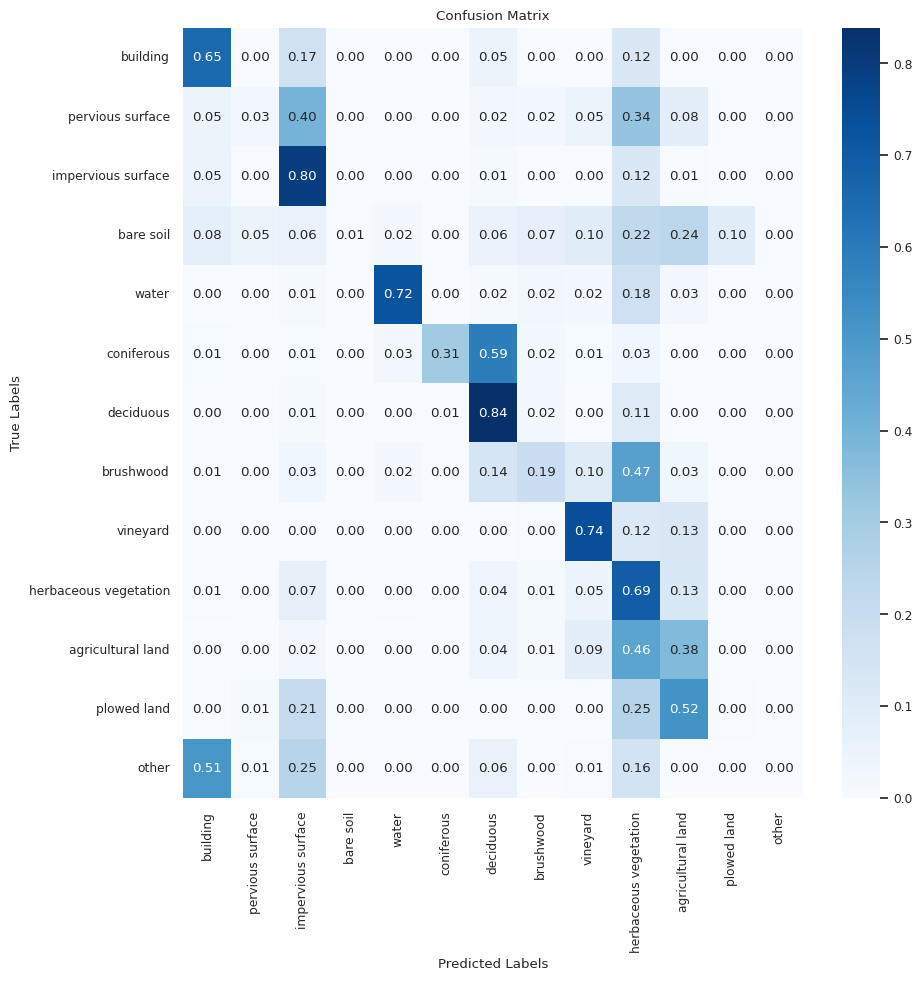

In [84]:
# create a new model's instance
model = DoubleSwinTransformerSegmentation(
        s1_backbone, s2_backbone, out_dim=data_config['num_classes'], device=device)

model = model.to(device)

# load checkpoints weights
model.load_state_dict(torch.load("checkpoints/segmentation-epoch-28.pth"))

test(model, test_loader)